## Chapter 17 - Metric Predicted Variable with One Metric Predictor

- [17.2 - Robust Linear Regression](#17.2---Robust-Linear-Regression)
- [17.3 - Hierarchical Regression on Individuals within Groups](#17.3---Hierarchical-Regression-on-Individuals-within-Groups)
- [17.4 - Quadratic Trend and Weighted Data](#17.4---Quadratic-Trend-and-Weighted-Data)

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib import gridspec
from IPython.display import Image

plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [2]:
%load_ext watermark
%watermark -p matplotlib,numpy,pandas,pymc,seaborn,scipy

matplotlib: 3.5.1
numpy     : 1.23.1
pandas    : 1.4.3
pymc      : 5.0.0
seaborn   : 0.12.2
scipy     : 1.8.1



In [3]:
def plot_grid(idata, data, sd_h, sd_w, mean_h, mean_w):
    """This function creates plots like figures 17.3 and 17.4 in the book."""

    fig = plt.figure(figsize=(13, 13))

    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2, 1:5])
    ax2 = plt.subplot(gs[2, :2])
    ax3 = plt.subplot(gs[2, 2:4])
    ax4 = plt.subplot(gs[2, 4:6])
    ax5 = plt.subplot(gs[3, :2])
    ax6 = plt.subplot(gs[3, 2:4])
    ax7 = plt.subplot(gs[3, 4:6])

    # Scatter plot of the observed data
    ax1.scatter(
        data.height,
        data.weight,
        s=40,
        linewidths=1,
        facecolor="none",
        edgecolor="k",
        zorder=10,
    )
    ax1.set_xlabel("height", fontdict=f_dict)
    ax1.set_ylabel("weight", fontdict=f_dict)
    ax1.set(xlim=(0, 80), ylim=(-350, 250))

    # Convert parameters to original scale
    beta0 = (
        idata.posterior["beta0"] * sd_w
        + mean_w
        - idata.posterior["beta1"] * mean_h * sd_w / sd_h
    )
    beta1 = idata.posterior["beta1"] * (sd_w / sd_h)
    sigma = idata.posterior["sigma"] * sd_w
    B = pd.DataFrame({"beta0": beta0.values.flatten(), "beta1": beta1.values.flatten()})

    # credible regression lines from posterior
    b0_hdi = np.round(az.hdi(B["beta0"].to_numpy(), hdi_prob=0.95))
    b1_hdi = np.round(az.hdi(B["beta1"].to_numpy(), hdi_prob=0.95))
    B_hdi = B[
        B["beta0"].between(*b0_hdi) & B["beta1"].between(*b1_hdi)
    ]
    xrange = np.arange(0, data.height.max() * 1.05)
    for i in np.random.randint(0, len(B_hdi), 30):
        ax1.plot(
            xrange,
            B_hdi.iloc[i, 0] + B_hdi.iloc[i, 1] * xrange,
            c=color,
            alpha=0.6,
            zorder=0,
        )

    # intercept
    pm.plot_posterior(beta0, point_estimate="mode", ax=ax2, color=color)
    ax2.set_xlabel(r"$\beta_0$", fontdict=f_dict)
    ax2.set_title("Intercept", fontdict={"weight": "bold"})

    # slope
    pm.plot_posterior(beta1, point_estimate="mode", ax=ax3, color=color, ref_val=0)
    ax3.set_xlabel(r"$\beta_1$", fontdict=f_dict)
    ax3.set_title("Slope", fontdict={"weight": "bold"})

    # scatter plot beta1, beta0
    ax4.scatter(beta1, beta0, edgecolor=color, facecolor="none", alpha=0.6)
    ax4.set_xlabel(r"$\beta_1$", fontdict=f_dict)
    ax4.set_ylabel(r"$\beta_0$", fontdict=f_dict)

    # scale
    pm.plot_posterior(sigma, point_estimate="mode", ax=ax5, color=color)
    ax5.set_xlabel(r"$\sigma$", fontdict=f_dict)
    ax5.set_title("Scale", fontdict={"weight": "bold"})

    # normality
    pm.plot_posterior(
        np.log10(idata.posterior["nu"]), point_estimate="mode", ax=ax6, color=color
    )
    ax6.set_xlabel(r"log10($\nu$)", fontdict=f_dict)
    ax6.set_title("Normality", fontdict={"weight": "bold"})

    # scatter plot normality, sigma
    ax7.scatter(
        np.log10(idata.posterior["nu"]),
        sigma,
        edgecolor=color,
        facecolor="none",
        alpha=0.6,
    )
    ax7.set_xlabel(r"log10($\nu$)", fontdict=f_dict)
    ax7.set_ylabel(r"$\sigma$", fontdict=f_dict)

    plt.tight_layout()

    return fig

In [4]:
def plot_cred_lines(beta0, beta1, x, sd_x, sd_y, mean_x, mean_y, ax):
    """This function plots credibility lines."""
    # Convert parameters to original scale
    beta0 = beta0 * sd_y + mean_y - beta1 * mean_x * sd_y / sd_x
    beta1 = beta1 * (sd_y / sd_x)
    B = pd.DataFrame({"beta0": beta0.values.flatten(), "beta1": beta1.values.flatten()})

    # Credible regression lines from posterior
    beta0_hdi = az.hdi(B["beta0"].to_numpy(), hdi_prob=0.95)
    beta1_hdi = az.hdi(B["beta1"].to_numpy(), hdi_prob=0.95)
    B_hdi = B[
        B["beta0"].between(*beta0_hdi) & B["beta1"].between(*beta1_hdi)
    ]
    #print([beta0_hdi, beta1_hdi, len(B_hdi)])
    xrange = np.arange(x.min() * 0.95, x.max() * 1.05)
    for i in np.random.randint(0, len(B_hdi), 30):
        ax.plot(
            xrange,
            B_hdi.iloc[i, 0] + B_hdi.iloc[i, 1] * xrange,
            c=color,
            alpha=0.6,
            zorder=0,
        )

In [5]:
def plot_quad_credlines(beta0, beta1, beta2, x, sd_x, sd_y, mean_x, mean_y, ax):
    """This function plots quadratic credibility lines."""
    # Convert parameters to original scale
    beta0 = (
        beta0 * sd_y
        + mean_y
        - beta1 * mean_x * sd_y / sd_x
        + beta2 * mean_x**2 * sd_y / sd_x**2
    )
    beta1 = beta1 * sd_y / sd_x - 2 * beta2 * mean_x * sd_y / sd_x**2
    beta2 = beta2 * sd_y / sd_x**2
    B = pd.DataFrame(
        {
            "beta0": beta0.values.flatten(),
            "beta1": beta1.values.flatten(),
            "beta2": beta2.values.flatten(),
        }
    )

    # credible regression lines from posterior
    beta0_hdi = az.hdi(B["beta0"].to_numpy(), hdi_prob=0.95)
    beta1_hdi = az.hdi(B["beta1"].to_numpy(), hdi_prob=0.95)
    beta2_hdi = az.hdi(B["beta2"].to_numpy(), hdi_prob=0.95)
    B_hdi = B[
        B["beta0"].between(*beta0_hdi)
        & B["beta1"].between(*beta1_hdi)
        & B["beta2"].between(*beta2_hdi)
    ]
    xrange = np.arange(x.min() - 1, x.max() + 2)
    for i in np.random.randint(0, len(B_hdi), 30):
        ax.plot(
            xrange,
            B_hdi.iloc[i, 0]
            + B_hdi.iloc[i, 1] * xrange
            + B_hdi.iloc[i, 2] * xrange**2,
            c=color,
            alpha=0.6,
            zorder=0,
        )

### 17.2 - Robust Linear Regression

#### Model (Kruschke, 2015)

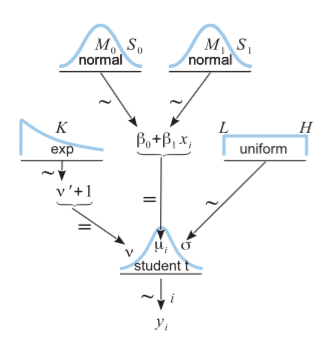

In [6]:
Image('images/fig17_2.png', width=400)

#### N = 30

In [7]:
df_n30 = pd.read_csv("data/HtWtData30.csv")
df_n30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    30 non-null     int64  
 1   height  30 non-null     float64
 2   weight  30 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 848.0 bytes


In [8]:
df_n30.head()

,male,height,weight
0,0,64.0,136.4
1,0,62.3,215.1
2,1,67.9,173.6
3,0,64.2,117.3
4,0,64.8,123.3


In [9]:
# standardize the data

zheight = (
    (df_n30["height"] - df_n30["height"].mean()) / df_n30["height"].std()
).to_numpy()
zweight = (
    (df_n30["weight"] - df_n30["weight"].mean()) / df_n30["weight"].std()
).to_numpy()

#### Model

In [10]:
with pm.Model() as model:

    beta0 = pm.Normal("beta0", mu=0, tau=1 / 10**2)
    beta1 = pm.Normal("beta1", mu=0, tau=1 / 10**2)
    mu = beta0 + beta1 * zheight

    sigma = pm.Uniform("sigma", 10**-3, 10**3)
    nu = pm.Exponential("nu", 1 / 29.0)

    likelihood = pm.StudentT("likelihood", nu, mu=mu, sigma=sigma, observed=zweight)

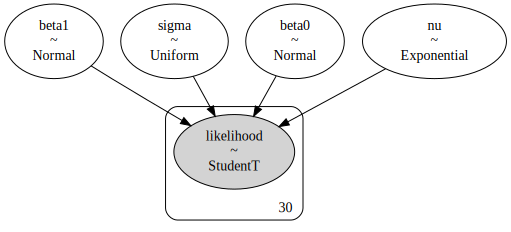

In [11]:
pm.model_to_graphviz(model)

In [12]:
with model:
    idata = pm.sample(5000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma, nu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


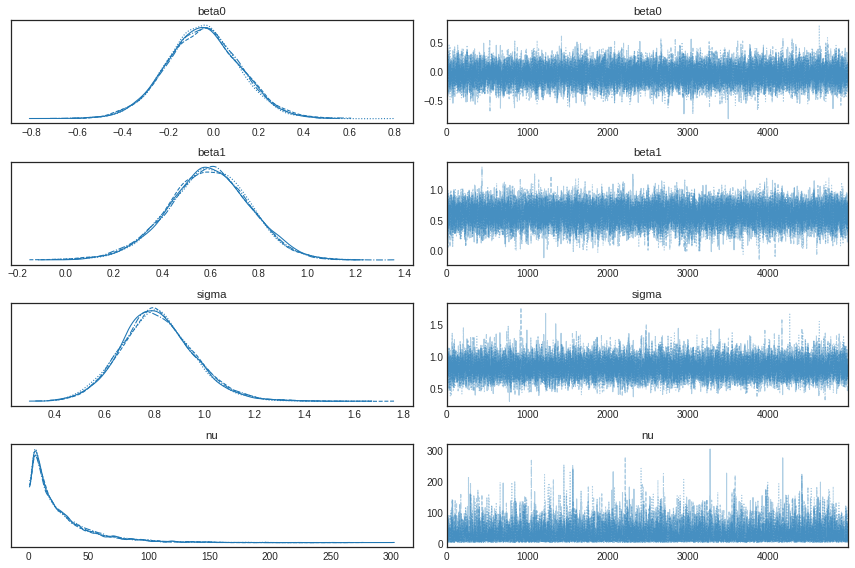

In [13]:
az.plot_trace(idata)
plt.tight_layout();

#### Figure 17.3

Note that these plots reflect the raw, unstandardized version of our posterior distributions over the model parameters, **not** the parameters we actually used in our model (and not the parameters we sampled).

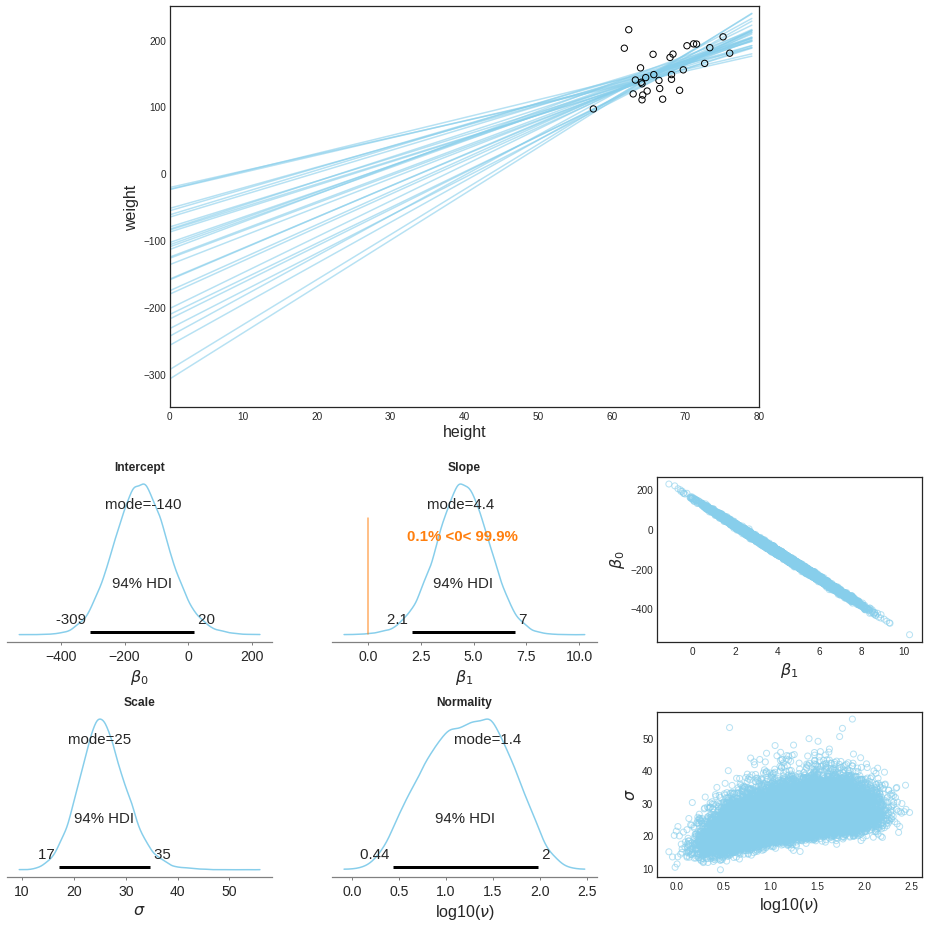

In [14]:
plot_grid(
    idata,
    df_n30,
    df_n30["height"].std(),
    df_n30["weight"].std(),
    df_n30["height"].mean(),
    df_n30["weight"].mean(),
);

#### N = 300

In [15]:
df_n300 = pd.read_csv("data/HtWtData300.csv")
df_n300.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    300 non-null    int64  
 1   height  300 non-null    float64
 2   weight  300 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.2 KB


In [16]:
# standardize the data

zheight2 = (
    (df_n300["height"] - df_n300["height"].mean()) / df_n300["height"].std()
).to_numpy()
zweight2 = (
    (df_n300["weight"] - df_n300["weight"].mean()) / df_n300["weight"].std()
).to_numpy()

#### Model

In [17]:
with pm.Model() as model2:

    beta0 = pm.Normal("beta0", mu=0, tau=1 / 10**2)
    beta1 = pm.Normal("beta1", mu=0, tau=1 / 10**2)
    mu = beta0 + beta1 * zheight2

    sigma = pm.Uniform("sigma", 10**-3, 10**3)
    nu = pm.Exponential("nu", 1 / 29)

    likelihood = pm.StudentT("likelihood", nu, mu=mu, sigma=sigma, observed=zweight2)

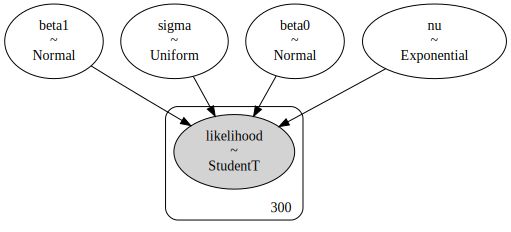

In [18]:
pm.model_to_graphviz(model2)

In [19]:
with model2:
    idata2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma, nu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


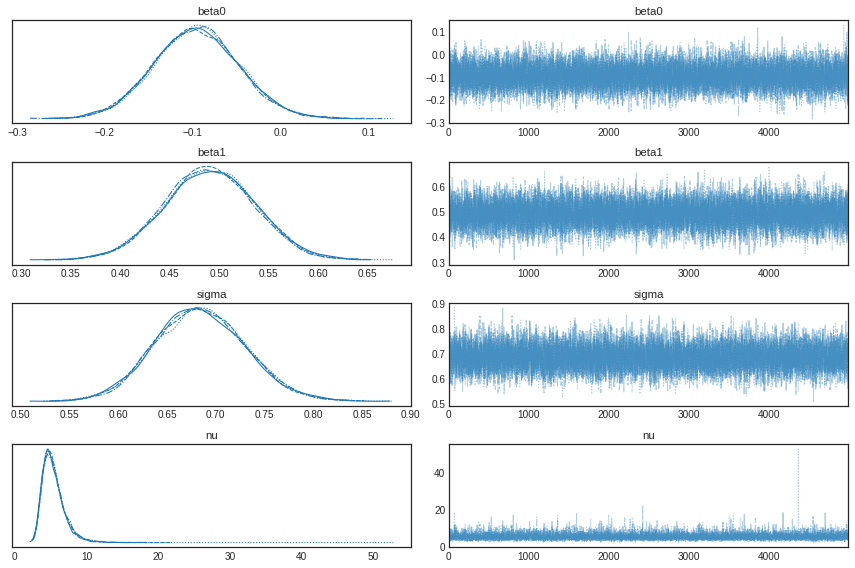

In [20]:
az.plot_trace(idata2)
plt.tight_layout();

#### Figure 17.4

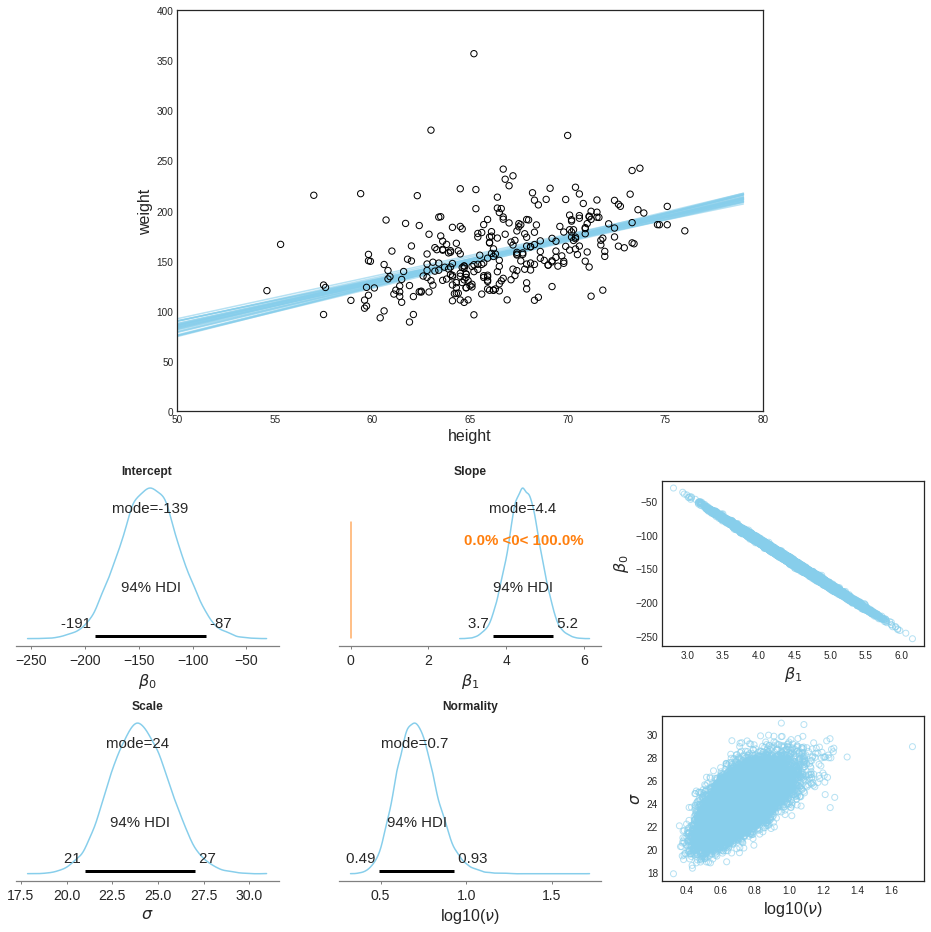

In [21]:
grid = plot_grid(
    idata2,
    df_n300,
    df_n300["height"].std(),
    df_n300["weight"].std(),
    df_n300["height"].mean(),
    df_n300["weight"].mean(),
)
grid.axes[0].set_xlim(50, 80)
grid.axes[0].set_ylim(0, 400);

### 17.3 - Hierarchical Regression on Individuals within Groups

#### Model (Kruschke, 2015)

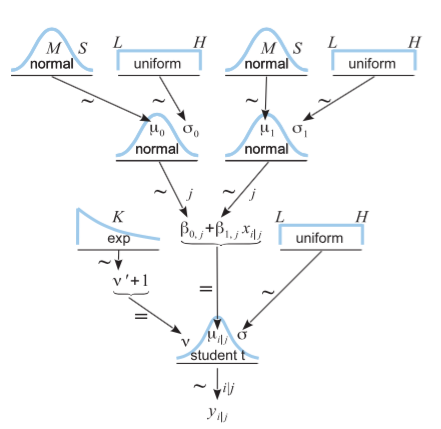

In [22]:
Image("images/fig17_6.png", width=500)

In [23]:
df_HRegr = pd.read_csv("data/HierLinRegressData.csv")
#df_HRegr.Subj = df_HRegr.Subj.astype("category")
#df_HRegr.Subj = df_HRegr.Subj.cat.as_ordered()
df_HRegr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Subj    132 non-null    int64  
 1   X       132 non-null    float64
 2   Y       132 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB


In [24]:
df_HRegr.head(10)

,Subj,X,Y
0,1,60.2,145.6
1,1,61.5,157.3
2,1,61.7,165.6
3,1,62.3,158.8
4,1,67.6,196.1
5,1,69.2,183.9
6,2,53.7,165.0
7,2,60.1,166.9
8,2,60.5,179.0
9,2,62.3,196.2


In [25]:
subj_idx, subj_codes = pd.factorize(df_HRegr["Subj"])
n_subj = df_HRegr["Subj"].nunique()

print("Number of groups: {}".format(n_subj))

Number of groups: 25


In [26]:
# Standardize the data

zx3 = ((df_HRegr["X"] - df_HRegr["X"].mean()) / df_HRegr["X"].std()).to_numpy()
zy3 = ((df_HRegr["Y"] - df_HRegr["Y"].mean()) / df_HRegr["Y"].std()).to_numpy()

#### Model
Reparameterization (centering) of hierarchical models can improve efficiency and speed of sampling.  
See http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/ and  
http://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html

**However**, do not assume that centered models will always be a better choice: https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html#32_Learning_the_Individual_Parameters.

In [27]:
with pm.Model() as model3:

    beta0 = pm.Normal("beta0", mu=0, tau=1 / 10**2)
    beta1 = pm.Normal("beta1", mu=0, tau=1 / 10**2)
    sigma0 = pm.Uniform("sigma0", 10**-3, 10**3)
    sigma1 = pm.Uniform("sigma1", 10**-3, 10**3)

    # this is the intuitive, centered specification
    # unfortunately, it results in a lot of divergences
    #beta0_s = pm.Normal("beta0_s", mu=beta0, sigma=sigma0, shape=n_subj)
    #beta1_s = pm.Normal("beta1_s", mu=beta1, sigma=sigma1, shape=n_subj)

    # this is the non-centered specification
    beta0_s_offset = pm.Normal("beta0_s_offset", mu=0, sigma=1, shape=n_subj)
    beta0_s = pm.Deterministic("beta0_s", beta0 + beta0_s_offset * sigma0)

    beta1_s_offset = pm.Normal("beta1_s_offset", mu=0, sigma=1, shape=n_subj)
    beta1_s = pm.Deterministic("beta1_s", beta1 + beta1_s_offset * sigma1)

    mu = beta0_s[subj_idx] + beta1_s[subj_idx] * zx3

    sigma = pm.Uniform("sigma", 10**-3, 10**3)
    nu = pm.Exponential("nu", 1 / 29.0)

    likelihood = pm.StudentT("likelihood", nu, mu=mu, sigma=sigma, observed=zy3)

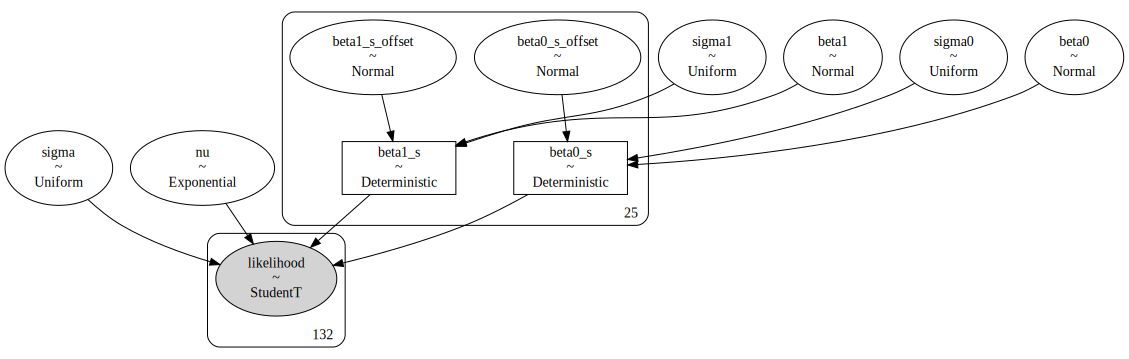

In [28]:
pm.model_to_graphviz(model3)

In [29]:
with model3:
    idata3 = pm.sample(5000, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma0, sigma1, beta0_s_offset, beta1_s_offset, sigma, nu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.


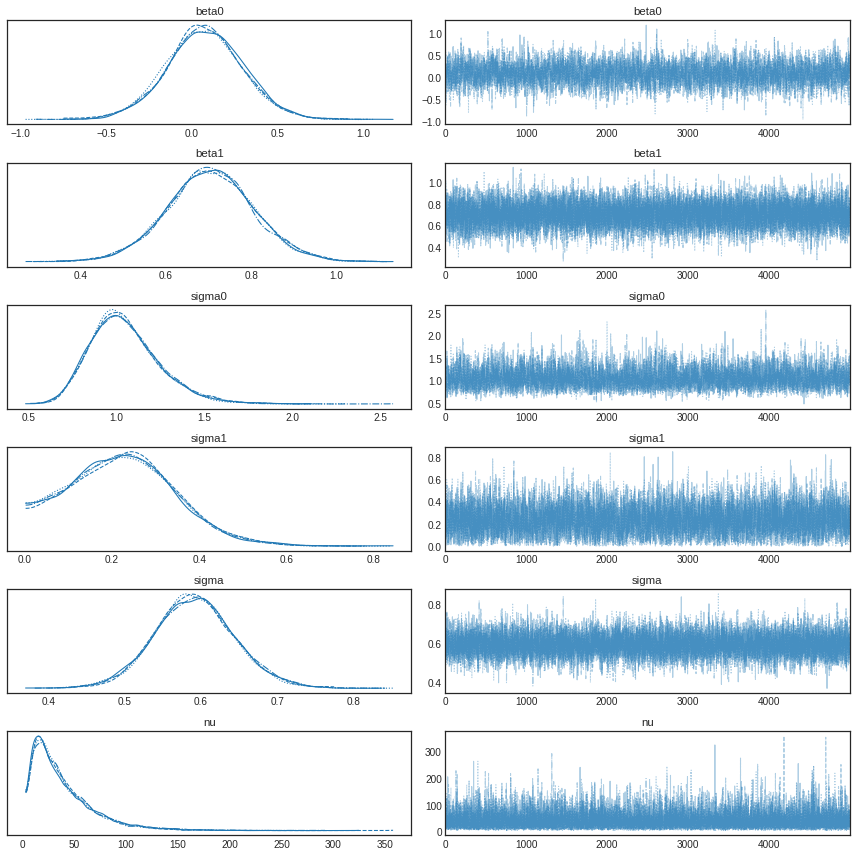

In [30]:
az.plot_trace(idata3, var_names=["beta0", "beta1", "sigma0", "sigma1", "sigma", "nu"])
plt.tight_layout();

#### Figure 17.5

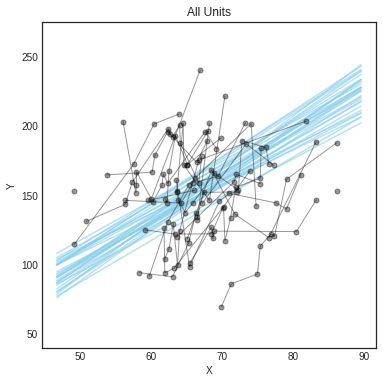

In [31]:
plt.figure(figsize=(6, 6))
ax = plt.gca()

df_HRegr.groupby("Subj").apply(
    lambda group: ax.plot(group.X, group.Y, "k-o", lw=1, markersize=5, alpha=0.4)
)
ax.set(xlabel="X", ylabel="Y", ylim=(40, 275), title="All Units")

plot_cred_lines(
    idata3.posterior["beta0"],
    idata3.posterior["beta1"],
    df_HRegr["X"],
    df_HRegr["X"].std(),
    df_HRegr["Y"].std(),
    df_HRegr["X"].mean(),
    df_HRegr["Y"].mean(),
    ax,
)

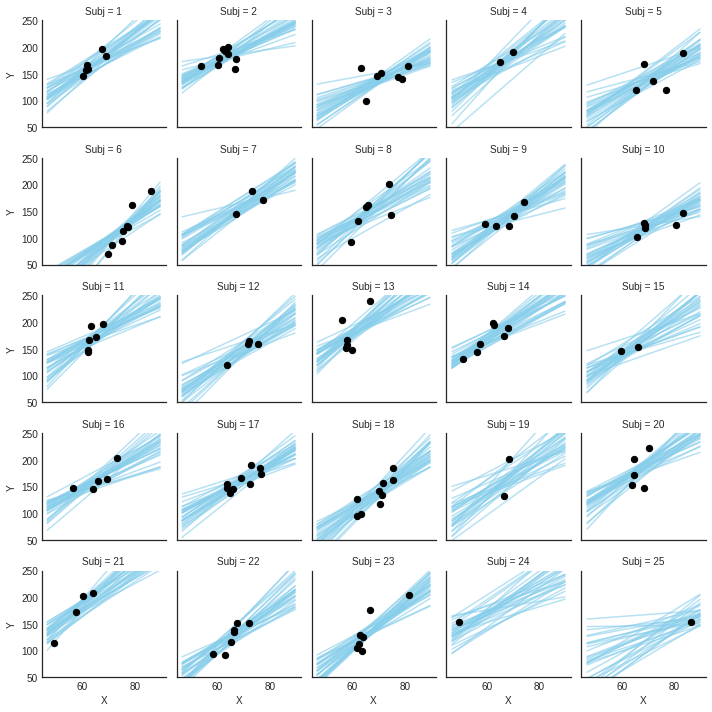

In [32]:
fg = sns.FacetGrid(df_HRegr, col="Subj", col_wrap=5, ylim=(50, 250), height=2)
fg.map(plt.scatter, "X", "Y", color="k", s=40)

for i, ax in enumerate(fg.axes):
    plot_cred_lines(
        idata3.posterior["beta0_s"].sel(beta0_s_dim_0=i),
        idata3.posterior["beta1_s"].sel(beta1_s_dim_0=i),
        df_HRegr["X"],
        df_HRegr["X"].std(),
        df_HRegr["Y"].std(),
        df_HRegr["X"].mean(),
        df_HRegr["Y"].mean(),
        ax,
    )

### 17.4 - Quadratic Trend and Weighted Data

In [33]:
df_income = pd.read_csv(
    "data/IncomeFamszState3yr.csv", skiprows=1, dtype={"State": "category"}
)
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   FamilySize    312 non-null    int64   
 1   State         312 non-null    category
 2   MedianIncome  312 non-null    int64   
 3   SampErr       312 non-null    int64   
dtypes: category(1), int64(3)
memory usage: 10.2 KB


In [34]:
df_income.head()

,FamilySize,State,MedianIncome,SampErr
0,2,Alabama,48177,581
1,3,Alabama,53323,1177
2,4,Alabama,64899,1170
3,5,Alabama,59417,2446
4,6,Alabama,54099,3781


In [35]:
state_idx, state_codes = pd.factorize(df_income["State"])
n_states = df_income["State"].nunique()

print(f"Number of states: {n_states}")

Number of states: 52


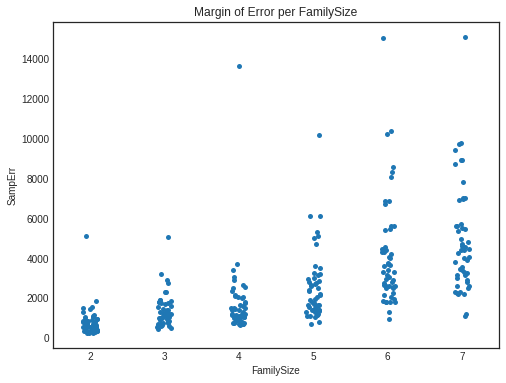

In [36]:
mean_fs = df_income["FamilySize"].mean()
sd_fs = df_income["FamilySize"].std()
z_fs = ((df_income["FamilySize"] - mean_fs) / sd_fs).to_numpy()

mean_income = df_income["MedianIncome"].mean()
sd_income = df_income["MedianIncome"].std()
z_income = ((df_income["MedianIncome"] - mean_income) / sd_income).to_numpy()

mean_error = df_income["SampErr"].mean()
z_error = (df_income["SampErr"] / mean_error).to_numpy()

# There are fewer large-sized families than small-sized families, making the medians for income
# for the former group noisier. We can modulate the noise parameter with the margin of error.
plt.figure(figsize=(8, 6))
sns.stripplot(x="FamilySize", y="SampErr", data=df_income)
plt.title("Margin of Error per FamilySize");

#### Model

In [37]:
with pm.Model(coords={"state":state_codes}) as model4:

    beta0 = pm.Normal("beta0", mu=0, tau=1 / 10**2)
    beta1 = pm.Normal("beta1", mu=0, tau=1 / 10**2)
    beta2 = pm.Normal("beta2", mu=0, tau=1 / 10**2)

    sigma0 = pm.Uniform("sigma0", 10**-3, 10**3)
    sigma1 = pm.Uniform("sigma1", 10**-3, 10**3)
    sigma2 = pm.Uniform("sigma2", 10**-3, 10**3)

    beta0_s = pm.Normal("beta0_s", mu=beta0, sigma=sigma0, dims="state")
    beta1_s = pm.Normal("beta1_s", mu=beta1, sigma=sigma1, dims="state")
    beta2_s = pm.Normal("beta2_s", mu=beta2, sigma=sigma2, dims="state")

    mu = beta0_s[state_idx] + beta1_s[state_idx] * z_fs + beta2_s[state_idx] * z_fs**2

    nu = pm.Exponential("nu", 1 / 29.0)
    sigma = pm.Uniform("sigma", 10**-3, 10**3)

    # Modulate the noise parameter with the margin of error.
    w_sigma = z_error * sigma

    likelihood = pm.StudentT(
        "likelihood", nu=nu, mu=mu, sigma=w_sigma, observed=z_income
    )

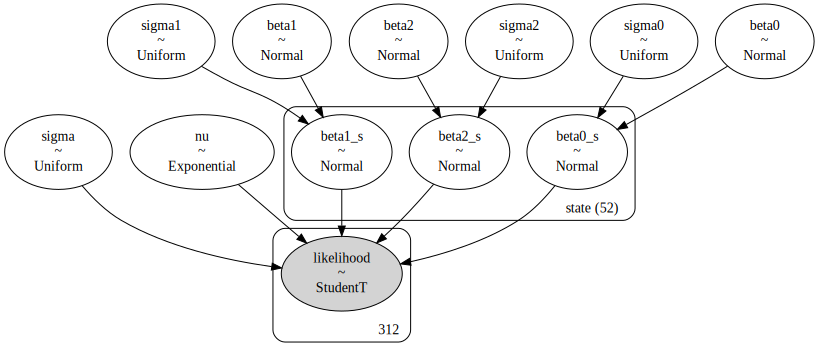

In [38]:
pm.model_to_graphviz(model4)

In [39]:
with model4:
    idata4 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, sigma0, sigma1, sigma2, beta0_s, beta1_s, beta2_s, nu, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 62 seconds.


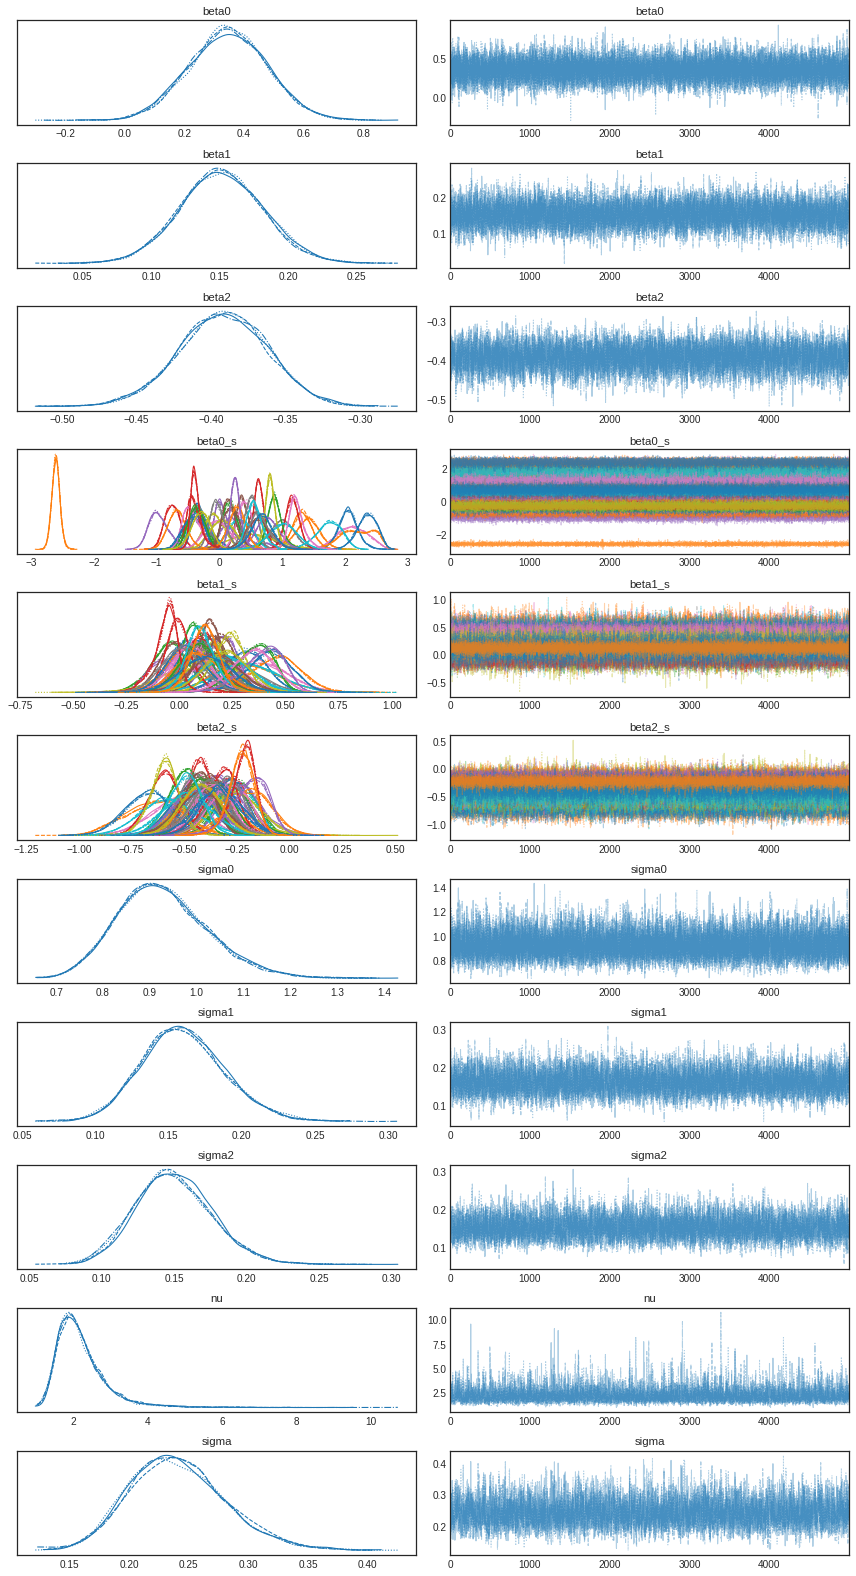

In [40]:
az.plot_trace(idata4)
plt.tight_layout();

In [41]:
az.summary(idata4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.346,0.132,0.091,0.584,0.001,0.001,22040.0,14183.0,1.0
beta1,0.152,0.030,0.092,0.207,0.000,0.000,7670.0,11897.0,1.0
beta2,-0.392,0.030,-0.448,-0.336,0.000,0.000,5258.0,10574.0,1.0
beta0_s[Alabama],-0.383,0.175,-0.689,-0.063,0.002,0.001,11697.0,13971.0,1.0
beta0_s[Alaska],1.404,0.197,1.017,1.766,0.001,0.001,17887.0,13335.0,1.0
...,...,...,...,...,...,...,...,...,...
sigma0,0.928,0.099,0.752,1.117,0.001,0.001,16137.0,12363.0,1.0
sigma1,0.160,0.028,0.106,0.213,0.000,0.000,5472.0,7293.0,1.0
sigma2,0.150,0.027,0.101,0.200,0.000,0.000,4549.0,7177.0,1.0
nu,2.212,0.689,1.219,3.380,0.011,0.008,3995.0,6760.0,1.0


#### Figure 17.7

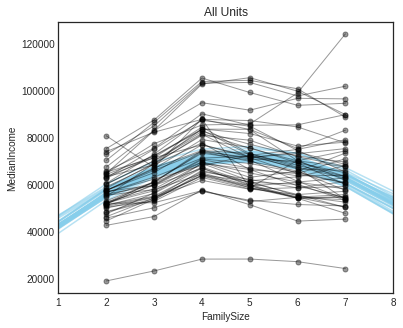

In [42]:
plt.figure(figsize=(6, 5))
ax = plt.gca()

df_income.groupby("State").apply(
    lambda group: ax.plot(
        group.FamilySize, group.MedianIncome, "k-o", lw=1, markersize=5, alpha=0.4
    )
)
ax.set(xlabel="FamilySize", ylabel="MedianIncome", xlim=(1, 8), title="All Units")

plot_quad_credlines(
    idata4.posterior["beta0"],
    idata4.posterior["beta1"],
    idata4.posterior["beta2"],
    df_income.FamilySize,
    sd_fs,
    sd_income,
    mean_fs,
    mean_income,
    ax,
);

/tmp/ipykernel_82554/1881504721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income_subset.loc[:,"State"] = df_income_subset.loc[:,"State"].cat.remove_unused_categories()


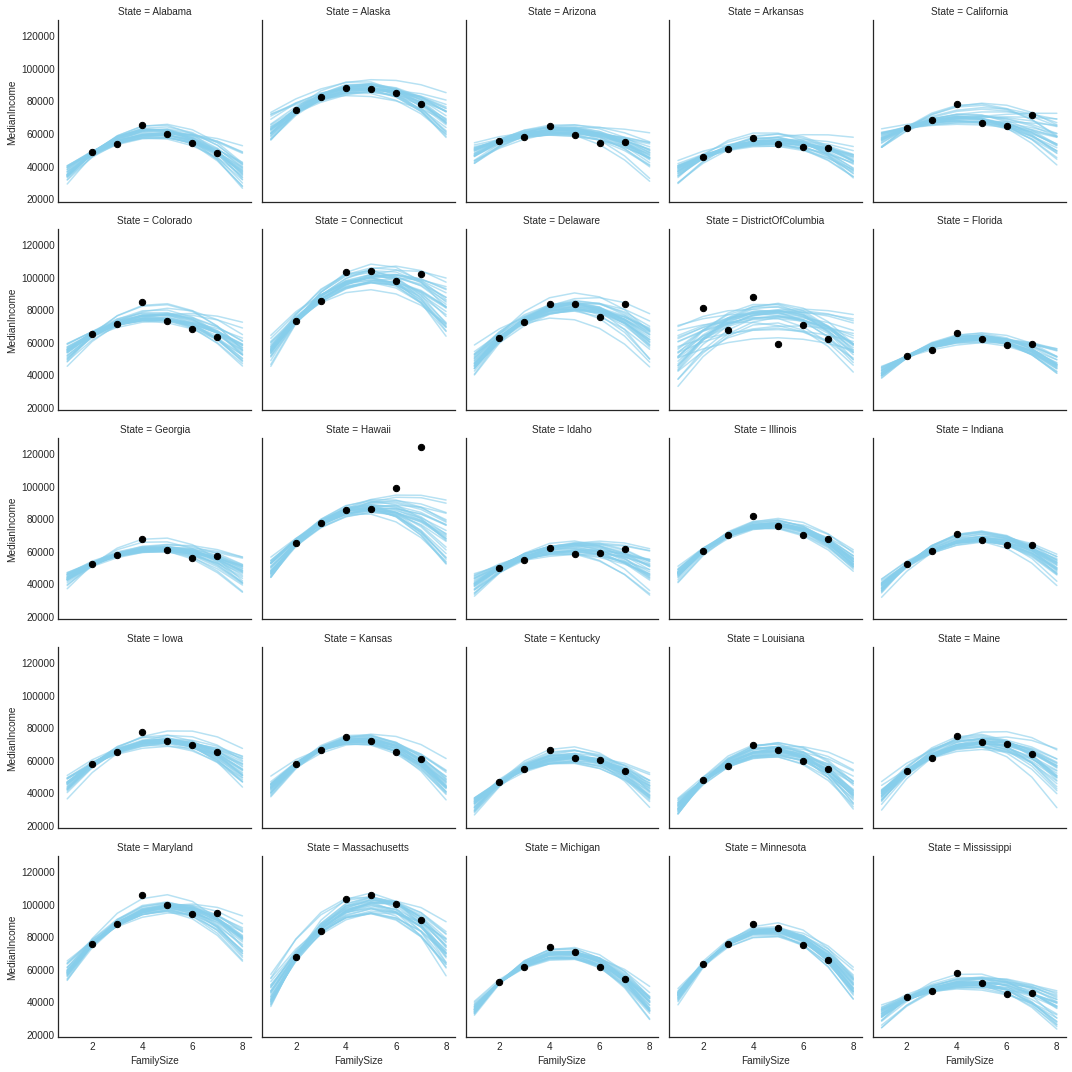

In [43]:
# the book shows the data for the first 25 States
states_to_plot = state_codes[:25]
df_income_subset = df_income[df_income["State"].isin(states_to_plot)]
df_income_subset.loc[:,"State"] = df_income_subset.loc[:,"State"].cat.remove_unused_categories()

fg = sns.FacetGrid(df_income_subset, col="State", col_wrap=5)
fg.map(plt.scatter, "FamilySize", "MedianIncome", color="k", s=40)

for ax,state in zip(fg.axes,states_to_plot):
    plot_quad_credlines(
        idata4.posterior["beta0_s"].sel(state=state),
        idata4.posterior["beta1_s"].sel(state=state),
        idata4.posterior["beta2_s"].sel(state=state),
        df_income_subset["FamilySize"],
        sd_fs,
        sd_income,
        mean_fs,
        mean_income,
        ax,
    );